In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from wordcloud import WordCloud
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import warnings
warnings.filterwarnings('ignore')


In [131]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')
test_data_hidden = pd.read_csv('test_data_hidden.csv')

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.16.2


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.16.2


In [132]:
train_data.info()
test_data.info()
test_data_hidden.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Name of the product  4000 non-null   object
 1   Product Brand        4000 non-null   object
 2   categories           4000 non-null   object
 3   primaryCategories    4000 non-null   object
 4   reviews.date         4000 non-null   object
 5   reviews.text         4000 non-null   object
 6   reviews.title        3990 non-null   object
 7   sentiment            4000 non-null   object
dtypes: object(8)
memory usage: 250.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Name of the product  1000 non-null   object
 1   Product Brand        1000 non-null   object
 2   categories           1000 non-null   object
 3   primary

In [133]:
train_data['reviews.title'].fillna('', inplace=True)
test_data['reviews.title'].fillna('', inplace=True)
test_data_hidden['reviews.title'].fillna('', inplace=True)


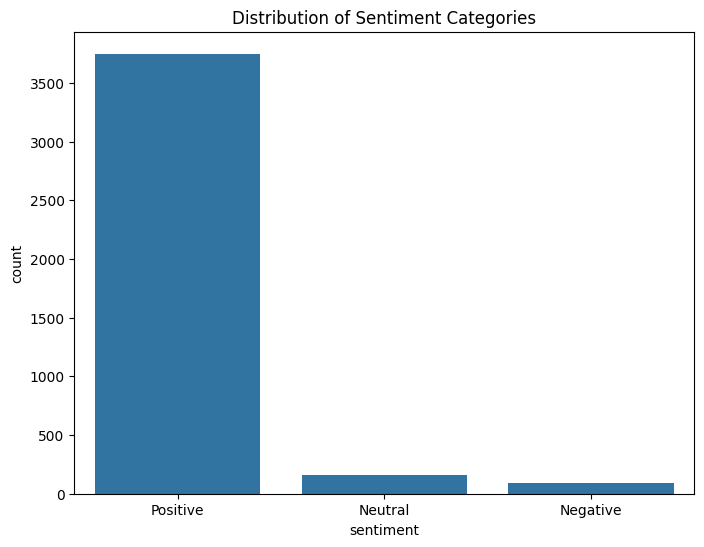

In [134]:
plt.figure(figsize=(8, 6))
sns.countplot(data=train_data, x='sentiment')
plt.title('Distribution of Sentiment Categories')
plt.show()

In [135]:
all_data = pd.concat([train_data, test_data])


In [136]:
most_frequent_sentiment = all_data['sentiment'].mode()[0]
all_data['sentiment'].fillna(most_frequent_sentiment, inplace=True)


In [137]:
train_data, test_data1 = train_test_split(all_data, test_size=0.2, stratify=all_data['sentiment'], random_state=42)

print(f'Training data shape: {train_data.shape}')
print(f'Test data shape: {test_data1.shape}')

Training data shape: (4000, 8)
Test data shape: (1000, 8)


In [138]:
train_data['combined_text'] = train_data['reviews.title'] + ' ' + train_data['reviews.text']
test_data1['combined_text'] = test_data1['reviews.title'] + ' ' + test_data1['reviews.text']
test_data_hidden['combined_text'] = test_data_hidden['reviews.title'] + ' ' + test_data_hidden['reviews.text']

# Separate texts for training, testing, and hidden test sets
X_train_texts = train_data['combined_text']
X_test_texts = test_data1['combined_text']
X_hidden_texts = test_data_hidden['combined_text']

In [139]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation)).lower()
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)


In [140]:
X_train_texts = X_train_texts.apply(preprocess_text)
X_test_texts = X_test_texts.apply(preprocess_text)
X_hidden_texts = X_hidden_texts.apply(preprocess_text)


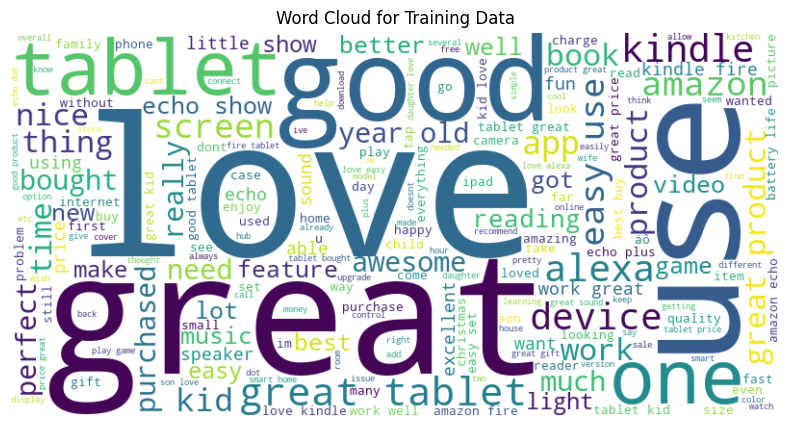

In [141]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(X_train_texts))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Training Data')
plt.show()

In [142]:
train_data1=train_data.copy()

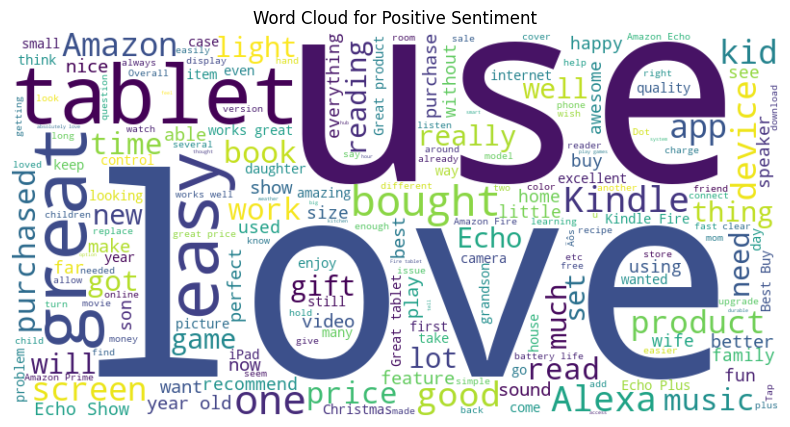

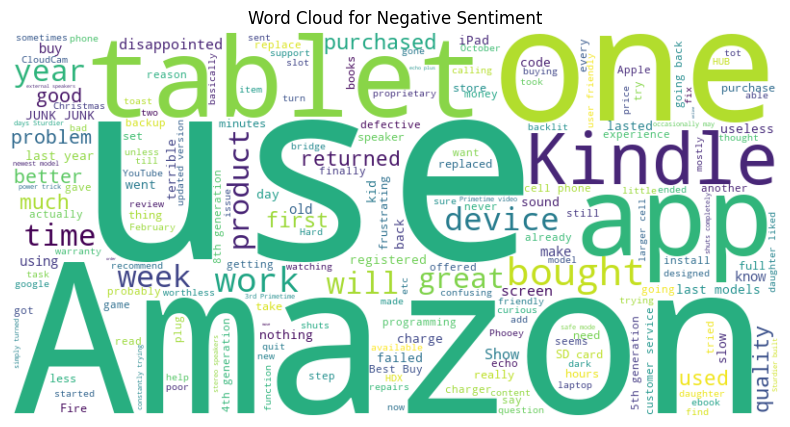

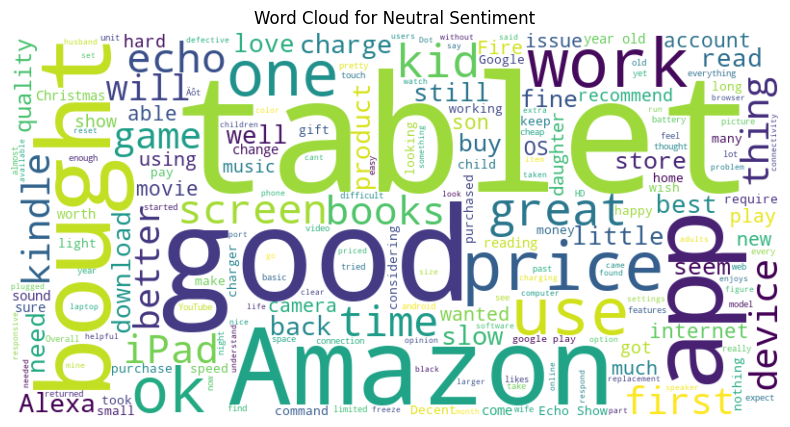

In [143]:
sentiments = ['Positive', 'Negative', 'Neutral']

# Convert sentiment column to lowercase
train_data1['sentiment'] = train_data1['sentiment'].str.lower()

# Iterate over lowercase sentiment categories and generate word clouds
for sentiment in sentiments:
    # Filter data for the current sentiment
    sentiment_data = train_data1[train_data1['sentiment'] == sentiment.lower()]
    
    if not sentiment_data.empty:
        # Join all texts corresponding to the current sentiment category
        text = ' '.join(sentiment_data['reviews.text'])
        
        # Generate word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

        # Plotting
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for {sentiment.capitalize()} Sentiment')
        plt.show()
    else:
        print(f"No data available for {sentiment} sentiment.")

In [144]:
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train_texts)
X_test_tfidf = tfidf.transform(X_test_texts)
X_hidden_tfidf = tfidf.transform(X_hidden_texts)

print(X_train_tfidf.shape, X_test_tfidf.shape, X_hidden_tfidf.shape)

(4000, 4996) (1000, 4996) (1000, 4996)


In [145]:
# Apply SMOTE to handle class imbalance in training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_tfidf, train_data['sentiment'])

# Check the new class distribution
print(pd.Series(y_train_res).value_counts())


sentiment
Positive    3799
Negative    3799
Neutral     3799
Name: count, dtype: int64


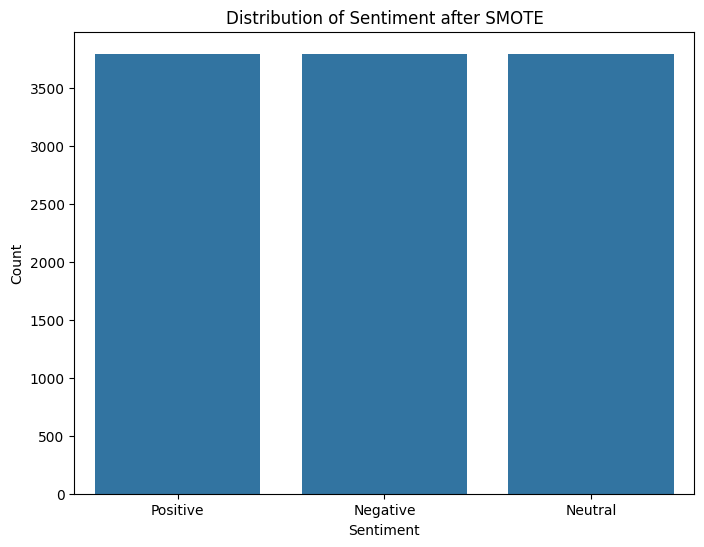

In [146]:
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_res)
plt.title('Distribution of Sentiment after SMOTE')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [147]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_res, y_train_res)

# Make predictions and evaluate the model
y_pred_nb = nb_classifier.predict(X_test_tfidf)

print(classification_report(test_data1['sentiment'], y_pred_nb))
print('Accuracy:', accuracy_score(test_data1['sentiment'], y_pred_nb))


              precision    recall  f1-score   support

    Negative       0.27      0.37      0.31        19
     Neutral       0.15      0.48      0.22        31
    Positive       0.97      0.89      0.93       950

    accuracy                           0.87      1000
   macro avg       0.46      0.58      0.49      1000
weighted avg       0.93      0.87      0.90      1000

Accuracy: 0.87


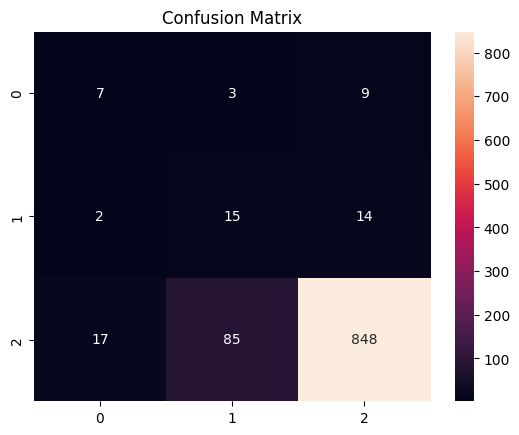

In [148]:
conf_matrix = confusion_matrix(test_data1['sentiment'], y_pred_nb)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

In [149]:
y_pred_prob_nb = nb_classifier.predict_proba(X_test_tfidf)
y_test_bin = pd.get_dummies(test_data1['sentiment'])
print("ROC AUC Score: ", roc_auc_score(y_test_bin, y_pred_prob_nb, multi_class='ovr'))

ROC AUC Score:  0.8671724014099373


In [150]:
svm_classifier = SVC(kernel='linear', probability=True, random_state=42)
svm_classifier.fit(X_train_res, y_train_res)

# Make predictions and evaluate the SVM model
y_pred_svm = svm_classifier.predict(X_test_tfidf)

print('SVM Accuracy:', accuracy_score(test_data1['sentiment'], y_pred_svm))
print('SVM Classification Report:\n', classification_report(test_data1['sentiment'], y_pred_svm))

SVM Accuracy: 0.94
SVM Classification Report:
               precision    recall  f1-score   support

    Negative       0.45      0.26      0.33        19
     Neutral       0.30      0.29      0.30        31
    Positive       0.97      0.97      0.97       950

    accuracy                           0.94      1000
   macro avg       0.57      0.51      0.53      1000
weighted avg       0.94      0.94      0.94      1000



In [152]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, solver='adam', random_state=42)
mlp_classifier.fit(X_train_res, y_train_res)

# Make predictions and evaluate the MLP model
y_pred_mlp = mlp_classifier.predict(X_test_tfidf)

print('MLP Accuracy:', accuracy_score(test_data1['sentiment'], y_pred_mlp))
print('MLP Classification Report:\n', classification_report(test_data1['sentiment'], y_pred_mlp))

MLP Accuracy: 0.942
MLP Classification Report:
               precision    recall  f1-score   support

    Negative       0.46      0.32      0.38        19
     Neutral       0.35      0.29      0.32        31
    Positive       0.96      0.98      0.97       950

    accuracy                           0.94      1000
   macro avg       0.59      0.53      0.55      1000
weighted avg       0.94      0.94      0.94      1000



In [153]:
ensemble = VotingClassifier(estimators=[
    ('nb', nb_classifier),
    ('svm', svm_classifier),
    ('mlp', mlp_classifier)
], voting='soft')

ensemble.fit(X_train_res, y_train_res)

# Make predictions using the ensemble
y_pred_ensemble = ensemble.predict(X_test_tfidf)

print('Ensemble Accuracy:', accuracy_score(test_data1['sentiment'], y_pred_ensemble))
print('Ensemble Classification Report:\n', classification_report(test_data1['sentiment'], y_pred_ensemble))

Ensemble Accuracy: 0.95
Ensemble Classification Report:
               precision    recall  f1-score   support

    Negative       0.71      0.26      0.38        19
     Neutral       0.39      0.23      0.29        31
    Positive       0.96      0.99      0.97       950

    accuracy                           0.95      1000
   macro avg       0.69      0.49      0.55      1000
weighted avg       0.94      0.95      0.94      1000



In [155]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode target variable in training set
y_train_encoded = label_encoder.fit_transform(y_train_res)


In [159]:
from xgboost import XGBClassifier

# Initialize XGBoost classifier
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Train the classifier on the resampled training data
xgb_classifier.fit(X_train_res, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [160]:
# Make predictions on the test set
y_pred_xgb = xgb_classifier.predict(X_test_tfidf)

# Convert numeric predictions back to string labels using LabelEncoder
y_pred_xgb_labels = label_encoder.inverse_transform(y_pred_xgb)

# Calculate accuracy using accuracy_score
accuracy_xgb = accuracy_score(test_data1['sentiment'], y_pred_xgb_labels)

# Print accuracy and classification report
print('XGBoost Accuracy:', accuracy_xgb)
print('XGBoost Classification Report:\n', classification_report(test_data1['sentiment'], y_pred_xgb_labels))

XGBoost Accuracy: 0.95
XGBoost Classification Report:
               precision    recall  f1-score   support

    Negative       0.43      0.16      0.23        19
     Neutral       0.41      0.29      0.34        31
    Positive       0.97      0.99      0.98       950

    accuracy                           0.95      1000
   macro avg       0.60      0.48      0.52      1000
weighted avg       0.94      0.95      0.94      1000



In [163]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_data['combined_text'])

X_train_seq = tokenizer.texts_to_sequences(train_data['combined_text'])
X_test_seq = tokenizer.texts_to_sequences(test_data1['combined_text'])

X_train_pad = pad_sequences(X_train_seq, maxlen=500)
X_test_pad = pad_sequences(X_test_seq, maxlen=500)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_res)
y_test_encoded = label_encoder.transform(test_data1['sentiment'])

y_train_cat = to_categorical(y_train_encoded, num_classes=3)
y_test_cat = to_categorical(y_test_encoded, num_classes=3)


In [165]:
# LSTM model architecture
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=500))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_pad, y_train_cat, epochs=10, batch_size=64, validation_split=0.2)

# Evaluate LSTM model
y_pred_lstm = model.predict(X_test_pad)
y_pred_lstm_classes = np.argmax(y_pred_lstm, axis=1)
print(classification_report(y_test_encoded, y_pred_lstm_classes))  # Use encoded test labels for classification report


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 437ms/step - accuracy: 0.9132 - loss: 0.5475 - val_accuracy: 0.9475 - val_loss: 0.2342
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 439ms/step - accuracy: 0.9548 - loss: 0.2137 - val_accuracy: 0.9475 - val_loss: 0.2273
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 423ms/step - accuracy: 0.9587 - loss: 0.1859 - val_accuracy: 0.9475 - val_loss: 0.2112
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 425ms/step - accuracy: 0.9493 - loss: 0.1637 - val_accuracy: 0.9488 - val_loss: 0.2122
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 447ms/step - accuracy: 0.9640 - loss: 0.1027 - val_accuracy: 0.9388 - val_loss: 0.2331
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 419ms/step - accuracy: 0.9779 - loss: 0.0772 - val_accuracy: 0.9450 - val_loss: 0.2762
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 429ms/step - accuracy: 0.9820 - loss: 0.0569 - val_accuracy: 0.9350 - val_loss: 0.2725
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 433ms/step - accuracy: 0.9871 - loss: 0.0499 - val_accu

history = model.fit(X_train_pad, y_train_cat, validation_data=(X_test_pad, y_test_cat), epochs=5, batch_size=64)

Epoch 1/10


50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 416ms/step - accuracy: 0.9918 - loss: 0.0239 - val_accuracy: 0.9362 - val_loss: 0.4299
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 425ms/step - accuracy: 0.9925 - loss: 0.0184 - val_accuracy: 0.9388 - val_loss: 0.4505
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 419ms/step - accuracy: 0.9964 - loss: 0.0132 - val_accuracy: 0.9425 - val_loss: 0.4298
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 428ms/step - accuracy: 0.9972 - loss: 0.0114 - val_accuracy: 0.9250 - val_loss: 0.4620
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 405ms/step - accuracy: 0.9992 - loss: 0.0061 - val_accuracy: 0.9400 - val_loss: 0.4612
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 421ms/step - accuracy: 0.9976 - loss: 0.0073 - val_accuracy: 0.9275 - val_loss: 0.4890
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 411ms/step - accuracy: 0.9948 - loss: 0.0110 - val_accuracy: 0.9325 - val_loss: 0.4642
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 407ms/step - accuracy: 0.9973 - loss: 0.0076 - val_accuracy: 0.942

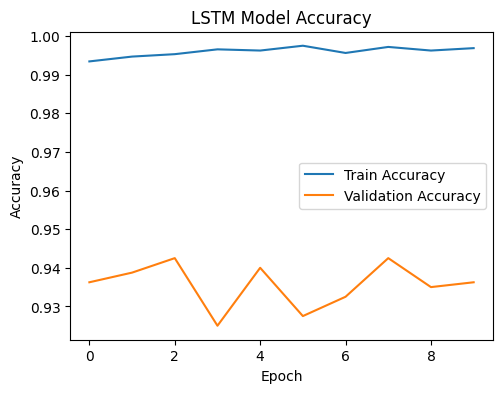

In [74]:
# Visualize accuracy and loss for LSTM training
history = model.fit(X_train_pad, y_train_cat, epochs=10, batch_size=64, validation_split=0.2)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

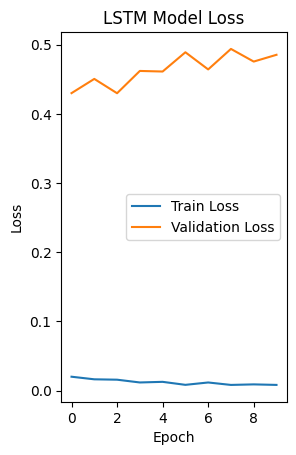

In [75]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [167]:
X_hidden_seq = tokenizer.texts_to_sequences(test_data_hidden['combined_text'])
X_hidden_pad = pad_sequences(X_hidden_seq, maxlen=500)

# Make predictions using the LSTM model on hidden test data
y_pred_hidden_lstm_prob = model.predict(X_hidden_pad)
y_pred_hidden_lstm = np.argmax(y_pred_hidden_lstm_prob, axis=1)

# Decode the predicted sentiments
y_pred_hidden_lstm_decoded = label_encoder.inverse_transform(y_pred_hidden_lstm)

# Add predictions to the hidden test data
test_data_hidden['predicted_sentiment'] = y_pred_hidden_lstm_decoded

# Save the predictions
test_data_hidden.to_csv('hidden_test_data_with_predictions.csv', index=False)

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step


In [6]:

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


ModuleNotFoundError: No module named 'tensorflow.keras.wrappers'

In [7]:

# Function to create LSTM model
def create_lstm_model():
    model = Sequential()
    model.add(Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=max_sequence_length))
    model.add(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(3, activation='softmax'))  # Assuming 3 output classes
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create KerasClassifier
lstm_model = KerasClassifier(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0)

NameError: name 'KerasClassifier' is not defined

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.16.2


In [176]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores_lstm = cross_val_score(lstm_model, X_train_tfidf, y_train_encoded, cv=5)
print(f'LSTM Cross-validation Accuracy: {np.mean(cv_scores_lstm):.4f} +/- {np.std(cv_scores_lstm):.4f}')

NameError: name 'lstm_model' is not defined

In [174]:
from sklearn.model_selection import RandomizedSearchCV

# Parameter grid
param_grid_lstm = {
    'units': [32, 64, 128],
    'dropout': [0.1, 0.2, 0.3],
    'recurrent_dropout': [0.1, 0.2, 0.3]
}

# Randomized search
random_search_lstm = RandomizedSearchCV(estimator=lstm_model, param_distributions=param_grid_lstm, n_iter=5, cv=3, verbose=2)
random_search_lstm.fit(X_train_tfidf, y_train_encoded)

print(f'Best parameters found for LSTM: {random_search_lstm.best_params_}')
print(f'Best cross-validation accuracy for LSTM: {random_search_lstm.best_score_:.4f}')

NameError: name 'lstm_model' is not defined

In [ ]:

# Example preprocessing steps
stop_words = set(stopwords.words('english'))

# Remove punctuation and lowercase
X_train_texts = [text.translate(str.maketrans('', '', string.punctuation)).lower() for text in X_train_texts]

# Tokenize and remove stopwords
X_train_texts = [" ".join([word for word in word_tokenize(text) if word not in stop_words]) for text in X_train_texts]

# Initialize Tf-Idf Vectorizer
tfidf = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
X_train_tfidf = tfidf.fit_transform(X_train_texts)

# LDA
lda = LatentDirichletAllocation(n_components=7, random_state=42)
X_lda = lda.fit_transform(X_train_tfidf)

# Display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Get feature names from tfidf vectorizer
feature_names = tfidf.get_feature_names_out()

# Use display_topics function
display_topics(lda, feature_names, 10)  # Adjust number of top words as needed

Topic 0:
echo great alexa love good show better job sound tap
Topic 1:
kindle hub bulb hue echo plus great design basic philips
Topic 2:
great tablet love use easy kids loves good product bought
Topic 3:
great product love good tablet one service amazon best works
Topic 4:
great good tablet screen like use fire alexa home product
Topic 5:
great like kindle love use light one alexa looks able
Topic 6:
toddler tablet great expected review battery good äôs life electronic
